Compare baseline with delimiter token scaling

In [8]:
import json
import glob
import os
import pandas as pd

# ==========================================
# 1. CONFIGURATION
# ==========================================

LOG_DIRECTORIES = {
    "Baseline": "/lustre/groups/eml/projects/huang/multi_image/lmms-eval/logs/baseline/",
    "Delimiter Scaling": "/lustre/groups/eml/projects/huang/multi_image/lmms-eval/logs/delimiter_scaling/"
}

# ==========================================
# 2. DATA EXTRACTION
# ==========================================

def get_primary_score(metrics):
    """Finds the first float value that isn't stderr/alias."""
    for key, val in metrics.items():
        if isinstance(val, (int, float)) and "stderr" not in key and "alias" not in key:
            return val * 100
    return None

all_rows = []

# Iterate through directories
for experiment_label, base_path in LOG_DIRECTORIES.items():
    # Find all JSON results recursively
    search_pattern = os.path.join(base_path, "**", "*_results.json")
    files = glob.glob(search_pattern, recursive=True)
    
    for file_path in files:
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
        except:
            continue

        # 1. Identify Model
        model_name = data.get('model_name_sanitized', data.get('model_name', 'Unknown'))
        
        row = {
            'Model': model_name,
            'Experiment': experiment_label
        }

        # 2. Extract Scores
        results = data.get('results', {})
        
        for task, metrics in results.items():
            score = get_primary_score(metrics)
            
            if score is None: continue

            # Map to readable column names
            if task == 'blink':
                row['BLINK (Overall)'] = score
            elif task == 'mantis':
                row['Mantis'] = score
            elif task == 'mirb':
                row['MIRB'] = score
            elif task == 'muirbench':
                row['MuirBench'] = score
            elif task.startswith('blink_'):
                # Clean subtask name: blink_art_style -> Art Style
                clean_name = task.replace('blink_', '').replace('_', ' ').title()
                row[clean_name] = score
        
        if len(row) > 2: # Only add if we found some metrics
            all_rows.append(row)

# ==========================================
# 3. DATAFRAME CREATION
# ==========================================

if all_rows:
    df = pd.DataFrame(all_rows)
    
    # Sort by Model first (versions together), then Experiment
    df = df.sort_values(by=['Model', 'Experiment']).reset_index(drop=True)

    # --- TABLE 1: MAIN BENCHMARKS ---
    main_benchmarks = ['BLINK (Overall)', 'Mantis', 'MIRB', 'MuirBench']
    
    # Filter columns that actually exist in the data
    valid_main_cols = [c for c in main_benchmarks if c in df.columns]
    
    if valid_main_cols:
        # Create Main DataFrame
        df_main = df[['Model', 'Experiment'] + valid_main_cols].copy()
        
        print("\n### 1. Main Benchmark Results")
        # Apply 'Blues' colormap: Darker = Higher Value
        display(
            df_main.style.format(precision=1, na_rep="-")
            .background_gradient(cmap='Blues', subset=valid_main_cols)
            .set_properties(**{'text-align': 'center'})
        )

    # --- TABLE 2: BLINK SUBTASKS ---
    # Identify subtask columns (cols not in main benchmarks and not metadata)
    meta_cols = ['Model', 'Experiment']
    subtask_cols = [c for c in df.columns if c not in main_benchmarks and c not in meta_cols]
    subtask_cols.sort()
    
    if subtask_cols:
        # Create Subtask DataFrame
        df_blink = df[meta_cols + subtask_cols].copy()
        
        print("\n### 2. BLINK Subtask Breakdown")
        # You can keep this one different (e.g., Greens) or same (Blues)
        display(
            df_blink.style.format(precision=1, na_rep="-")
            .background_gradient(cmap='Blues', subset=subtask_cols)
            .set_properties(**{'text-align': 'center'})
        )

else:
    print("No data found.")


### 1. Main Benchmark Results


,Model,Experiment,BLINK (Overall),Mantis,MIRB,MuirBench
0,Qwen__Qwen2.5-VL-3B-Instruct,Baseline,47.2,62.2,58.0,35.3
1,Qwen__Qwen2.5-VL-3B-Instruct,Delimiter Scaling,45.1,59.4,57.5,37.4
2,Qwen__Qwen2.5-VL-7B-Instruct,Baseline,55.9,70.5,63.3,44.3
3,Qwen__Qwen2.5-VL-7B-Instruct,Delimiter Scaling,52.4,67.7,57.1,42.3



### 2. BLINK Subtask Breakdown


,Model,Experiment,Art Style,Counting,Forensic Detection,Functional Correspondence,Iq Test,Jigsaw,Multi View Reasoning,Object Localization,Relative Depth,Relative Reflectance,Semantic Correspondence,Spatial Relation,Visual Correspondence,Visual Similarity
0,Qwen__Qwen2.5-VL-3B-Instruct,Baseline,61.5,65.0,28.8,19.2,26.0,45.3,44.4,59.0,66.1,39.6,28.8,82.5,32.0,62.2
1,Qwen__Qwen2.5-VL-3B-Instruct,Delimiter Scaling,58.1,65.8,20.5,21.5,20.7,45.3,44.4,58.2,66.1,33.6,25.2,83.2,29.1,59.3
2,Qwen__Qwen2.5-VL-7B-Instruct,Baseline,68.4,70.8,43.9,23.1,26.7,66.0,54.9,54.1,75.0,35.1,33.8,90.2,53.5,87.4
3,Qwen__Qwen2.5-VL-7B-Instruct,Delimiter Scaling,65.0,70.0,32.6,24.6,24.7,57.3,51.1,54.9,69.4,37.3,31.7,89.5,49.4,76.3


In [11]:
import json
import glob
import os
import pandas as pd

# ==========================================
# 1. CONFIGURATION
# ==========================================

LOG_DIRECTORIES = {
    "Baseline": "/lustre/groups/eml/projects/huang/multi_image/lmms-eval/logs/baseline/",
    "Delimiter Scaling": "/lustre/groups/eml/projects/huang/multi_image/lmms-eval/logs/delimiter_scaling/"
}

# ==========================================
# 2. HELPER FUNCTIONS
# ==========================================

def normalize_val(val):
    """Normalizes answers (e.g., '4.0' -> '4', 'Yes' -> 'yes')."""
    s = str(val).strip().lower()
    try:
        f_val = float(s)
        if f_val.is_integer():
            return str(int(f_val))
    except:
        pass
    return s

def calculate_acc(correct, total):
    return (correct / total * 100) if total > 0 else 0.0

def parse_muirbench(file_path):
    stats = {} 
    total_correct = 0
    total_count = 0
    
    try:
        with open(file_path, 'r') as f:
            for line in f:
                entry = json.loads(line)
                info = entry.get('muirbench_score_overall', {})
                if not info: continue
                
                task = info.get('task', 'Unknown')
                pred = normalize_val(info.get('pred', ''))
                ans  = normalize_val(info.get('answer', ''))
                
                is_correct = (pred == ans)
                
                # Update Subtask Stats
                if task not in stats: stats[task] = {'c': 0, 't': 0}
                stats[task]['t'] += 1
                if is_correct: stats[task]['c'] += 1
                
                # Update Overall Stats
                total_count += 1
                if is_correct: total_correct += 1
                
    except Exception as e:
        return None
        
    # Build Result Dict
    results = {k: calculate_acc(v['c'], v['t']) for k, v in stats.items()}
    results['Overall'] = calculate_acc(total_correct, total_count)
    return results

def parse_mirb(file_path):
    stats = {}
    total_correct = 0
    total_count = 0
    
    try:
        with open(file_path, 'r') as f:
            for line in f:
                entry = json.loads(line)
                info = entry.get('mirb_score', {})
                if not info: continue
                
                subset = info.get('subset', 'Unknown')
                
                # Handle List Predictions
                pred_raw = info.get('pred_answer', [])
                pred_val = pred_raw[0] if isinstance(pred_raw, list) and pred_raw else pred_raw
                
                pred = normalize_val(pred_val)
                ans  = normalize_val(info.get('answers', ''))
                
                is_correct = (pred == ans)
                
                # Update Subset Stats
                if subset not in stats: stats[subset] = {'c': 0, 't': 0}
                stats[subset]['t'] += 1
                if is_correct: stats[subset]['c'] += 1
                
                # Update Overall Stats
                total_count += 1
                if is_correct: total_correct += 1
                
    except Exception as e:
        return None
        
    # Build Result Dict
    results = {k: calculate_acc(v['c'], v['t']) for k, v in stats.items()}
    results['Overall'] = calculate_acc(total_correct, total_count)
    return results

# ==========================================
# 3. MAIN EXECUTION
# ==========================================

muir_rows = []

for experiment_label, base_path in LOG_DIRECTORIES.items():
    results_files = glob.glob(os.path.join(base_path, "**", "*_results.json"), recursive=True)
    
    for res_file in results_files:
        dir_name = os.path.dirname(res_file)
        base_name = os.path.basename(res_file).replace('_results.json', '')
        
        try:
            with open(res_file, 'r') as f:
                meta = json.load(f)
                model_name = meta.get('model_name_sanitized', meta.get('model_name', 'Unknown'))
        except:
            continue
            
        # MuirBench
        muir_path = os.path.join(dir_name, f"{base_name}_samples_muirbench.jsonl")
        if os.path.exists(muir_path):
            scores = parse_muirbench(muir_path)
            if scores:
                row = {'Model': model_name, 'Experiment': experiment_label}
                row.update(scores)
                muir_rows.append(row)
                
        
# ==========================================
# 4. DISPLAY
# ==========================================

def display_table(data_rows, title):
    if not data_rows:
        return

    df = pd.DataFrame(data_rows)
    
    # 1. Sort Rows
    df = df.sort_values(by=['Model', 'Experiment']).reset_index(drop=True)
    
    # 2. Sort Columns
    meta = ['Model', 'Experiment']
    
    # Get all other columns
    others = [c for c in df.columns if c not in meta]
    
    # Force 'Overall' to be first, then sort the rest alphabetically
    if 'Overall' in others:
        others.remove('Overall')
        metrics = ['Overall'] + sorted(others)
    else:
        metrics = sorted(others)
        
    final_cols = meta + metrics
    df = df[final_cols]
    
    print(f"\n### {title}")
    display(
        df.style.format(precision=1, na_rep="-")
        .background_gradient(cmap='Blues', subset=metrics)
        .set_properties(**{'text-align': 'center'})
    )

display_table(muir_rows, "MuirBench Task Breakdown (with Overall)")


### MuirBench Task Breakdown (with Overall)


,Model,Experiment,Overall,Action Understanding,Attribute Similarity,Cartoon Understanding,Counting,Diagram Understanding,Difference Spotting,Geographic Understanding,Image-Text Matching,Ordering,Scene Understanding,Visual Grounding,Visual Retrieval
0,Qwen__Qwen2.5-VL-3B-Instruct,Baseline,35.3,35.4,49.5,42.3,37.2,35.9,25.6,21.0,39.9,9.4,59.1,33.3,21.6
1,Qwen__Qwen2.5-VL-3B-Instruct,Delimiter Scaling,37.4,33.5,49.0,44.9,34.2,36.9,27.6,20.0,43.5,15.6,62.9,33.3,30.1
2,Qwen__Qwen2.5-VL-7B-Instruct,Baseline,44.3,40.9,46.9,44.9,37.2,60.6,32.6,23.0,62.9,18.8,58.6,34.5,18.5
3,Qwen__Qwen2.5-VL-7B-Instruct,Delimiter Scaling,42.3,42.1,40.8,44.9,38.0,48.7,30.6,16.0,63.1,28.1,64.0,36.9,17.5


In [ ]:
import json
import glob
import os
import pandas as pd

# ==========================================
# 1. CONFIGURATION
# ==========================================

LOG_DIRECTORIES = {
    "Baseline": "/lustre/groups/eml/projects/huang/multi_image/lmms-eval/logs/baseline/",
    "Delimiter Scaling": "/lustre/groups/eml/projects/huang/multi_image/lmms-eval/logs/delimiter_scaling/"
}

# ==========================================
# 2. EVALUATION LOGIC (MMMU / MIRB Style)
# ==========================================

def normalize_str(s):
    """
    Approximation of MMMU normalize_str.
    Returns a list containing the normalized value (float or string).
    """
    if s is None:
        return []
    
    # Try converting to float first
    try:
        return [float(s)]
    except ValueError:
        pass
    
    # Otherwise normalize string
    if isinstance(s, str):
        return [s.strip().lower()]
    return [str(s)]

def eval_multi_choice(gold_i, pred_i):
    """
    Evaluate a multiple choice instance.
    https://github.com/MMMU-Benchmark/MMMU/blob/51ce7f3e829c16bb44bc5445782686b4c3508794/eval/eval_utils.py#L175
    """
    correct = False
    # only they are exactly the same, we consider it as correct
    if isinstance(gold_i, list):
        for answer in gold_i:
            if answer == pred_i:
                correct = True
                break
    else:  # gold_i is a string
        if gold_i == pred_i:
            correct = True
    return correct


def eval_open(gold_i, pred_i):
    """
    Evaluate an open question instance
    https://github.com/MMMU-Benchmark/MMMU/blob/51ce7f3e829c16bb44bc5445782686b4c3508794/eval/eval_utils.py#L191
    """
    correct = False
    if isinstance(gold_i, list):
        # use float to avoid trivial matches
        norm_answers = []
        for answer in gold_i:
            norm_answers.extend(normalize_str(answer))
    else:
        norm_answers = normalize_str(gold_i)
    for pred in pred_i:  # pred is already normalized in parse response phase
        if isinstance(pred, str):  # if it's a string, then find if ans in the pred_i
            for norm_ans in norm_answers:
                # only see if the string answer in the string pred
                if isinstance(norm_ans, str) and norm_ans in pred:
                    if not correct:
                        correct = True
                    break
        else:  # it's a float number
            if pred in norm_answers:
                if not correct:
                    correct = True
                break
    return correct

def parse_mirb_advanced(file_path):
    stats = {}
    total_correct = 0
    total_count = 0
    
    try:
        with open(file_path, 'r') as f:
            for line in f:
                entry = json.loads(line)
                info = entry.get('mirb_score', {})
                if not info: continue
                
                subset = info.get('subset', 'Unknown')
                pred_answer = info.get('pred_answer', [])
                answers = info.get('answers', '')
                
                # --- DETERMINE EVALUATION METHOD ---
                # Logic: If answer is single letter A-E, treat as MCQ
                is_mcq = False
                if isinstance(answers, str) and answers.strip().upper() in ["A", "B", "C", "D", "E"]:
                    is_mcq = True
                
                # --- EVALUATE ---
                if is_mcq:
                    is_correct = eval_multi_choice(answers, pred_answer)
                else:
                    is_correct = eval_open(answers, pred_answer)
                
                # --- UPDATE STATS ---
                if subset not in stats: stats[subset] = {'c': 0, 't': 0}
                stats[subset]['t'] += 1
                if is_correct: stats[subset]['c'] += 1
                
                total_count += 1
                if is_correct: total_correct += 1
                
    except Exception as e:
        print(f"Error parsing {file_path}: {e}")
        return None
        
    # Calculate Percentages
    results = {k: (v['c'] / v['t'] * 100) for k, v in stats.items()}
    results['Overall'] = (total_correct / total_count * 100) if total_count > 0 else 0.0
    
    return results

# ==========================================
# 3. MAIN EXECUTION
# ==========================================

mirb_rows = []

for experiment_label, base_path in LOG_DIRECTORIES.items():
    results_files = glob.glob(os.path.join(base_path, "**", "*_results.json"), recursive=True)
    
    for res_file in results_files:
        dir_name = os.path.dirname(res_file)
        base_name = os.path.basename(res_file).replace('_results.json', '')
        
        try:
            with open(res_file, 'r') as f:
                meta = json.load(f)
                model_name = meta.get('model_name_sanitized', meta.get('model_name', 'Unknown'))
        except:
            continue
            
        # Process MIRB with Advanced Logic
        mirb_path = os.path.join(dir_name, f"{base_name}_samples_mirb.jsonl")
        if os.path.exists(mirb_path):
            scores = parse_mirb_advanced(mirb_path)
            if scores:
                row = {'Model': model_name, 'Experiment': experiment_label}
                row.update(scores)
                mirb_rows.append(row)

# ==========================================
# 4. DISPLAY TABLE
# ==========================================

if mirb_rows:
    df_mirb = pd.DataFrame(mirb_rows)
    
    # Sort Rows
    df_mirb = df_mirb.sort_values(by=['Model', 'Experiment']).reset_index(drop=True)
    
    # Sort Columns (Overall first, then alphabetical)
    meta = ['Model', 'Experiment']
    others = [c for c in df_mirb.columns if c not in meta]
    
    if 'Overall' in others:
        others.remove('Overall')
        cols = meta + ['Overall'] + sorted(others)
    else:
        cols = meta + sorted(others)
        
    print("\n### 4. MIRB Subset Breakdown (Corrected Evaluation)")
    display(
        df_mirb[cols].style.format(precision=1, na_rep="-")
        .background_gradient(cmap='Blues', subset=cols[2:])
        .set_properties(**{'text-align': 'center'})
    )
else:
    print("No MIRB data found.")


### 4. MIRB Subset Breakdown (Corrected Evaluation)


,Model,Experiment,Overall,3d_scene,analogy,arxiv,attribute,codeu,count,food,image_jigsaw,plot_code,sightseeing,visual_chain
0,Qwen__Qwen2.5-VL-3B-Instruct,Baseline,58.0,32.0,34.0,78.9,64.0,90.7,59.3,55.0,27.0,65.9,88.2,77.4
1,Qwen__Qwen2.5-VL-3B-Instruct,Delimiter Scaling,57.5,38.0,33.0,71.9,64.0,88.9,58.7,52.0,28.0,54.5,90.2,79.0
2,Qwen__Qwen2.5-VL-7B-Instruct,Baseline,63.3,17.0,40.0,84.2,65.0,88.9,64.0,71.0,37.0,88.6,92.2,93.5
3,Qwen__Qwen2.5-VL-7B-Instruct,Delimiter Scaling,57.1,12.0,36.0,82.5,65.0,90.7,58.7,54.0,19.0,72.7,91.2,93.5


Starting Data Extraction...

Processing Model: Qwen__Qwen2.5-VL-7B-Instruct


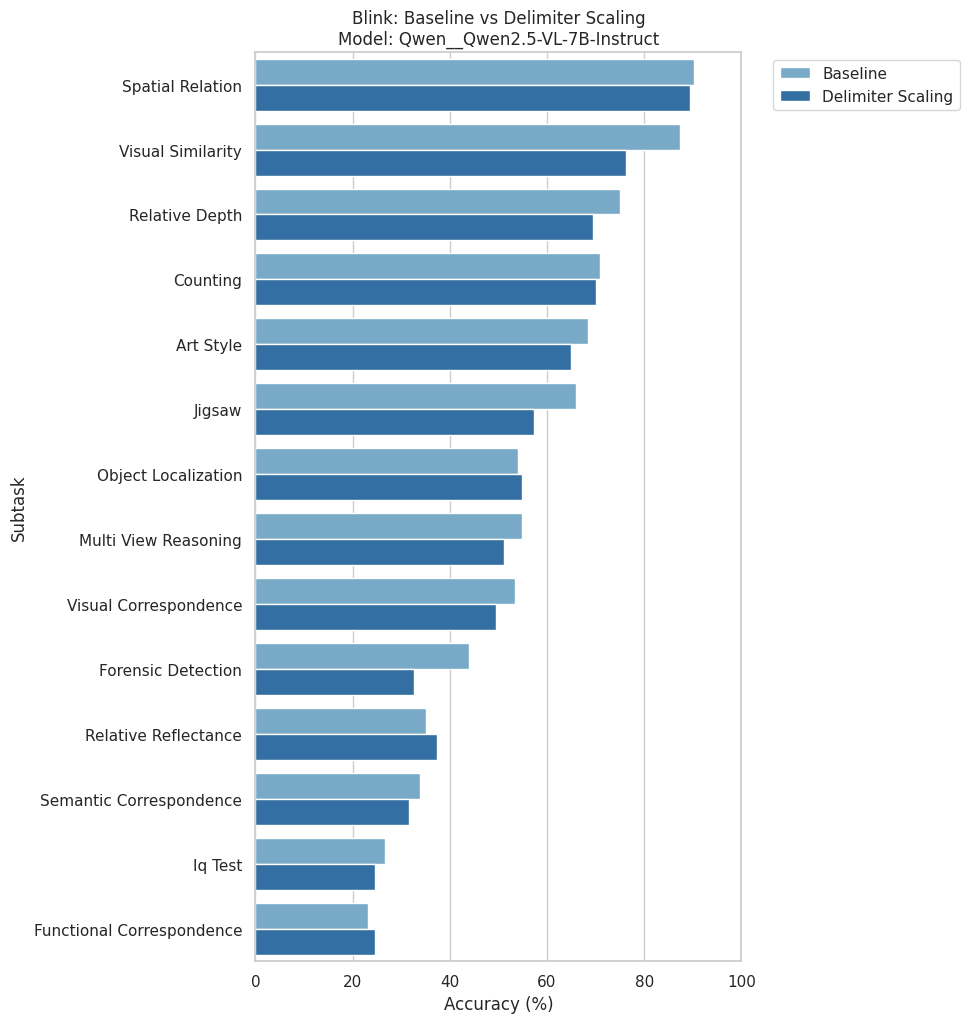

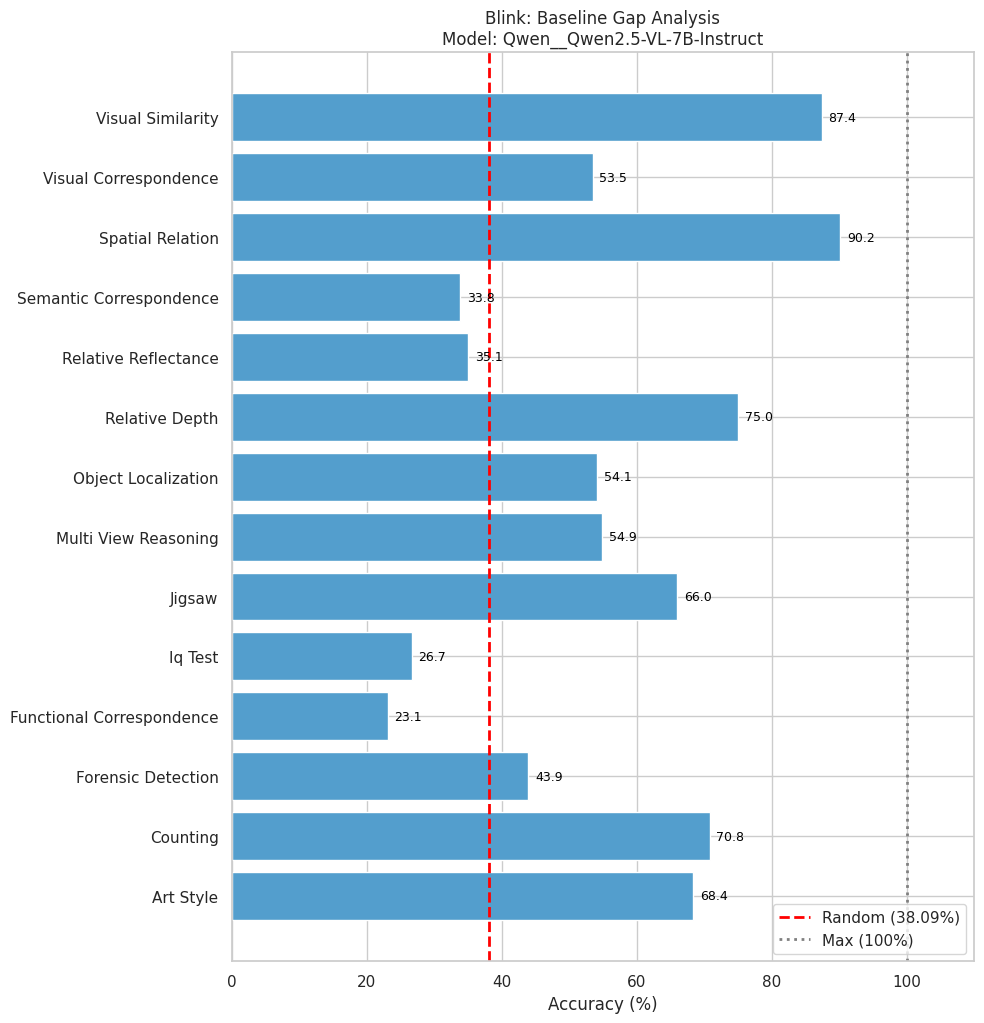

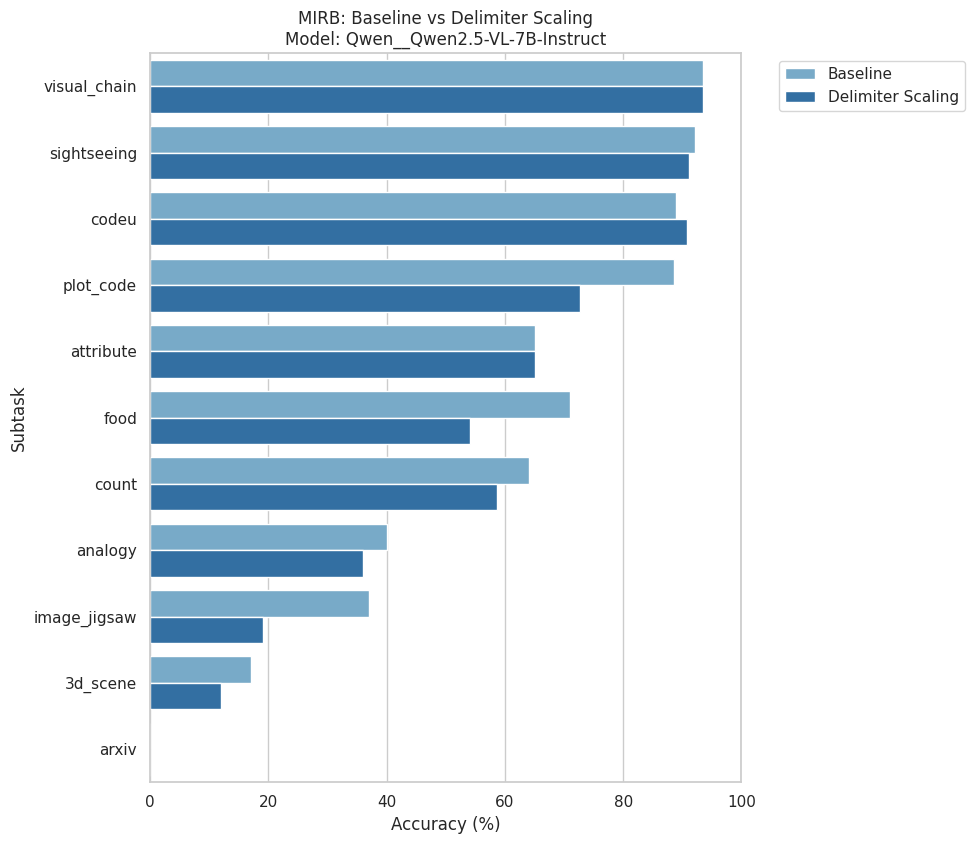

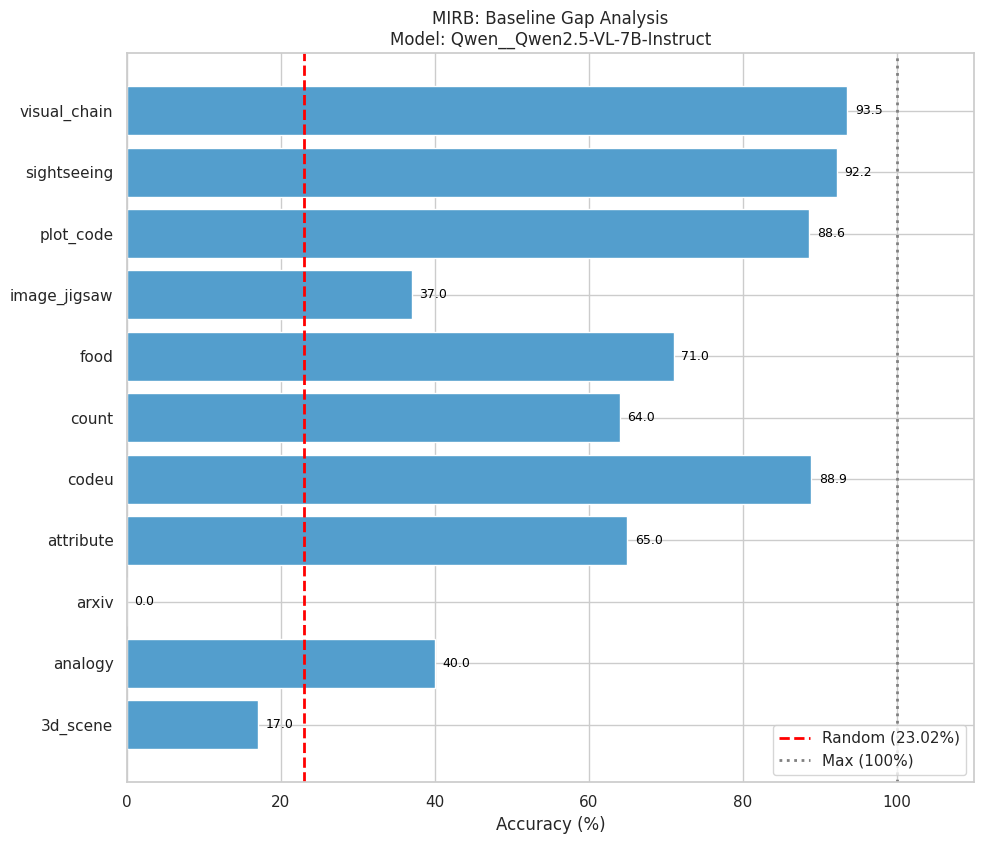

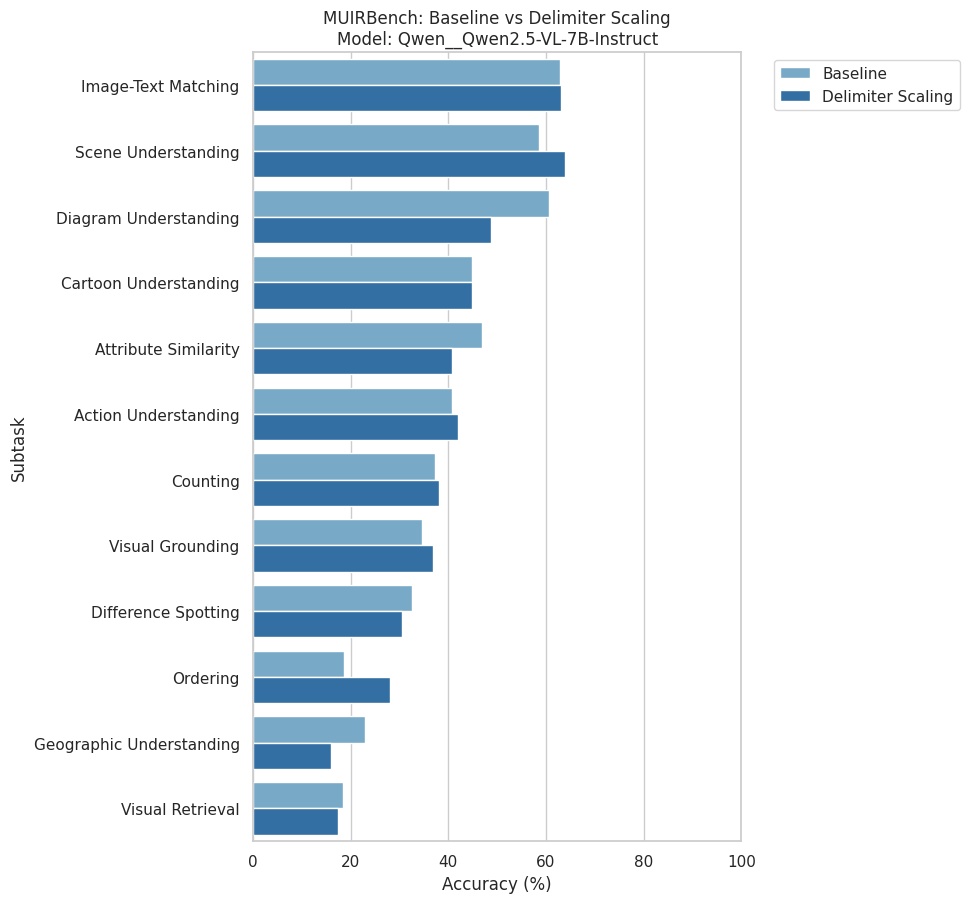

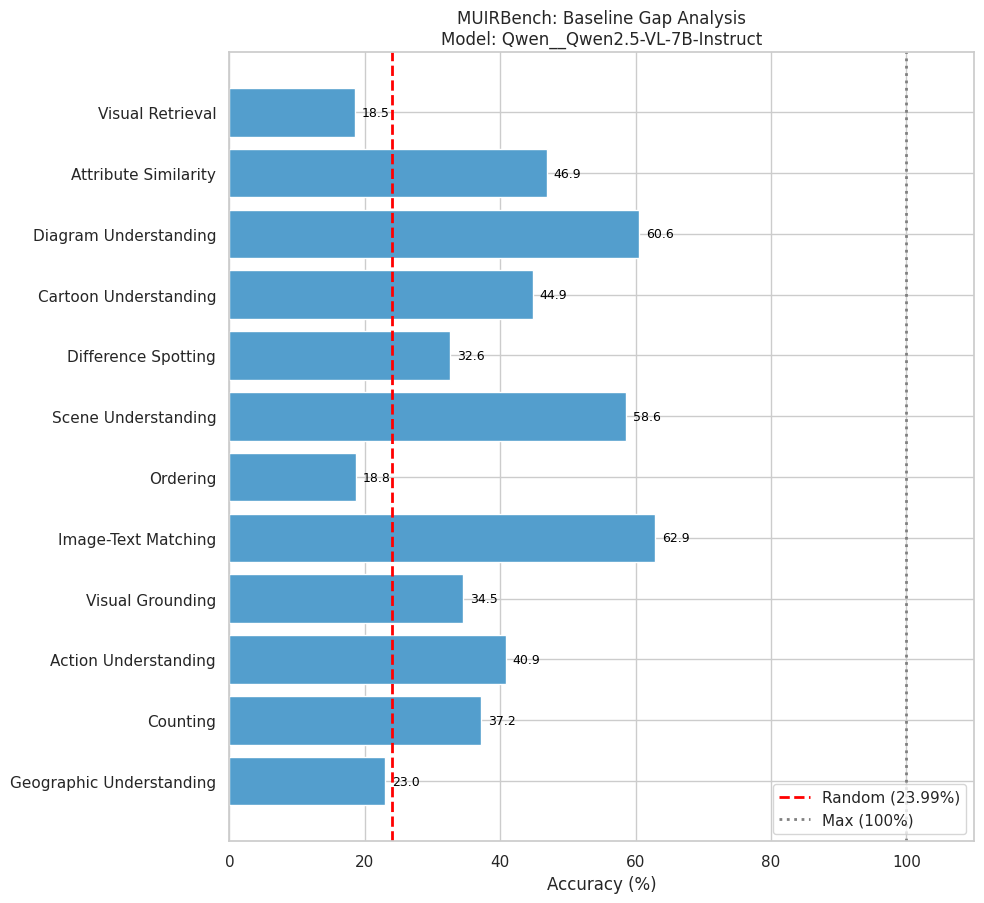


Processing Model: Qwen__Qwen2.5-VL-3B-Instruct


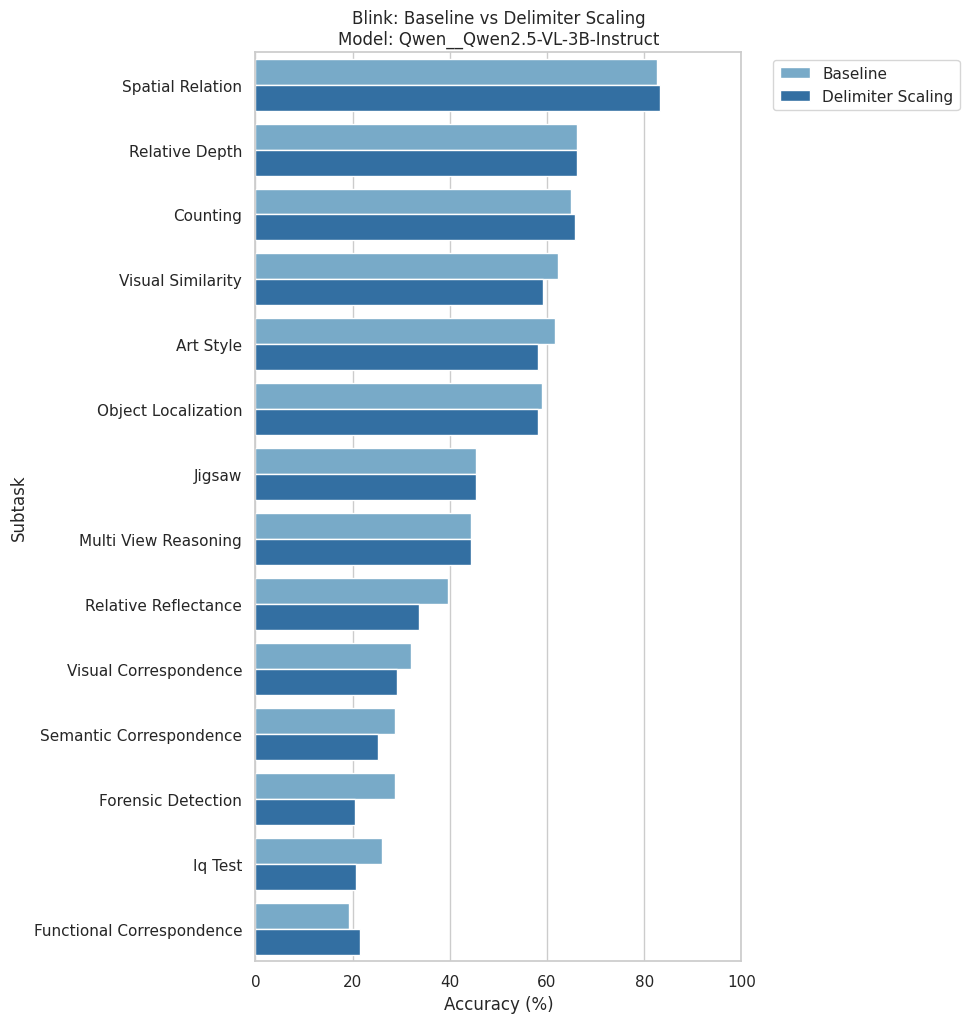

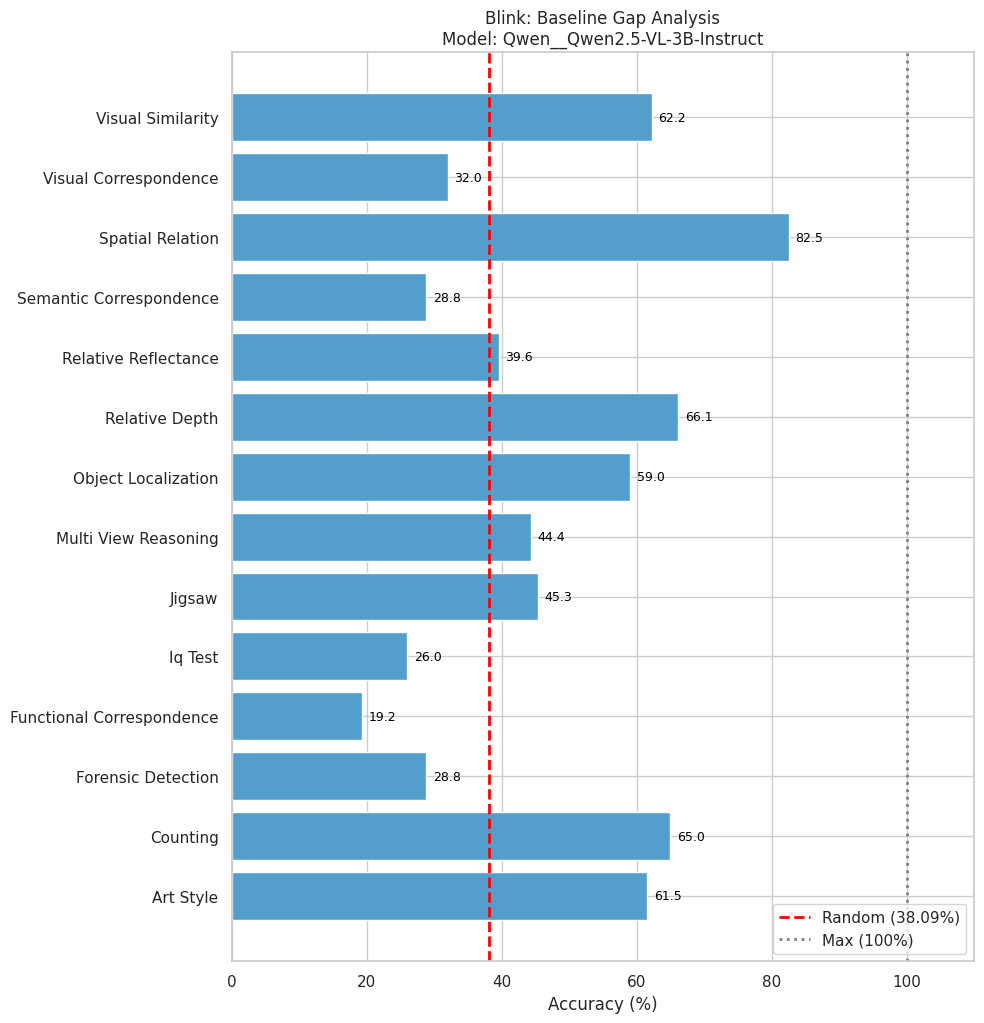

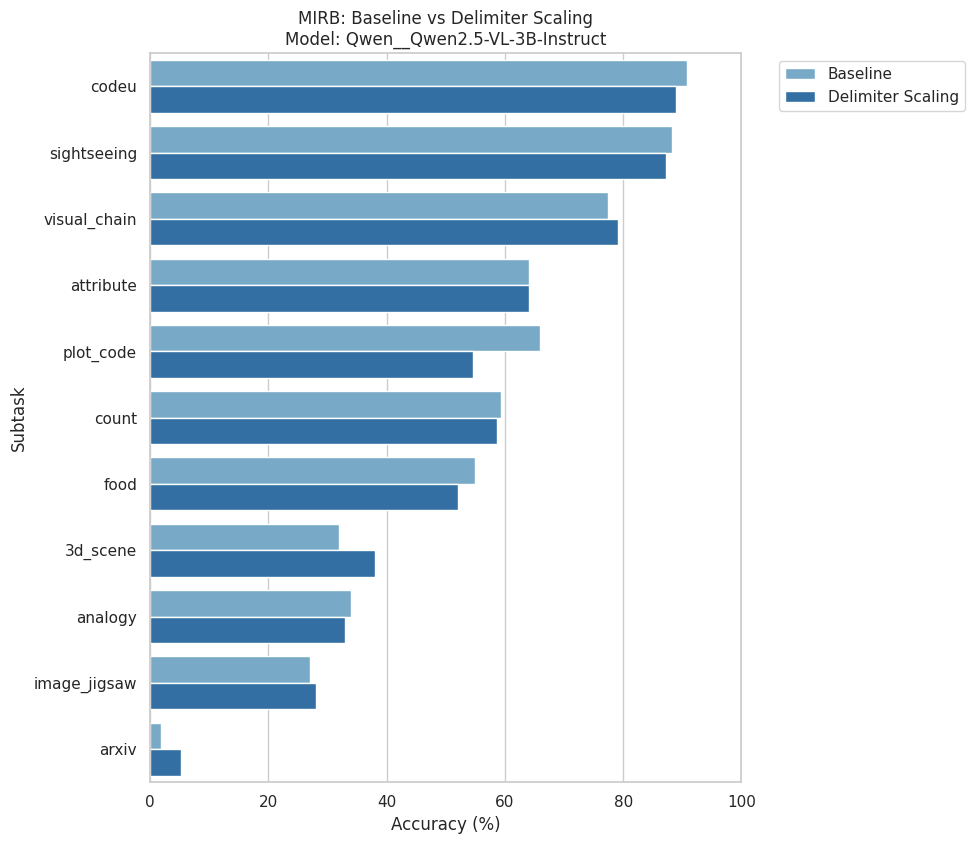

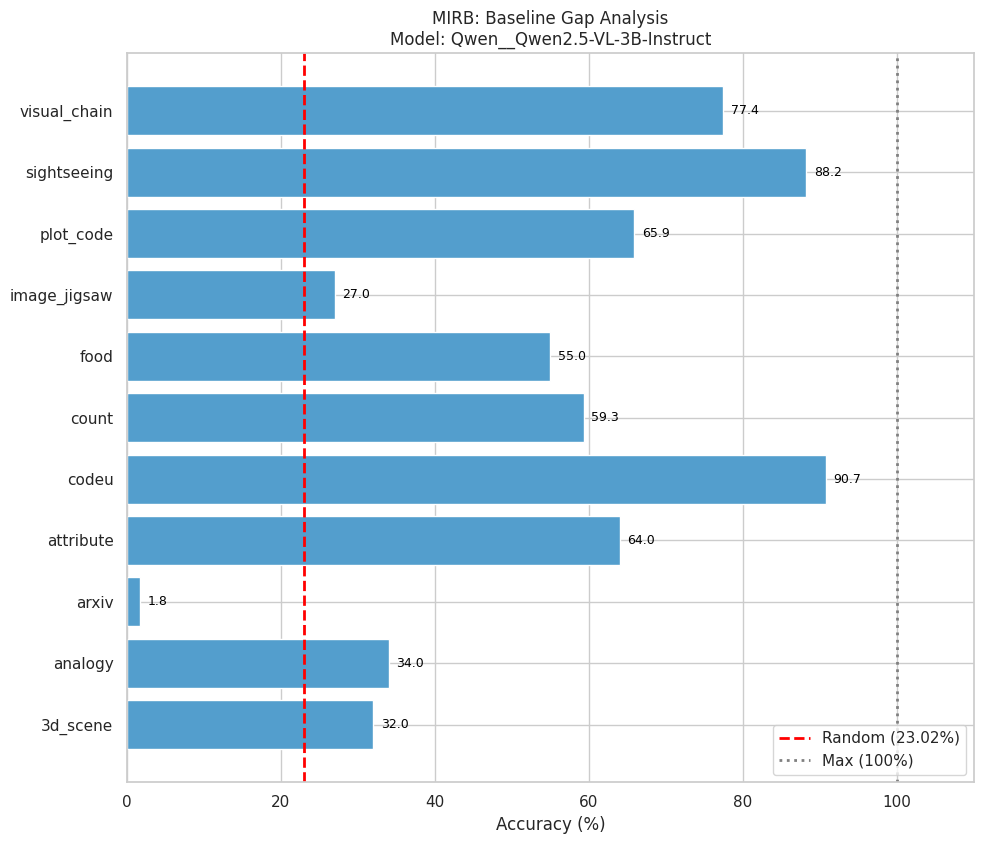

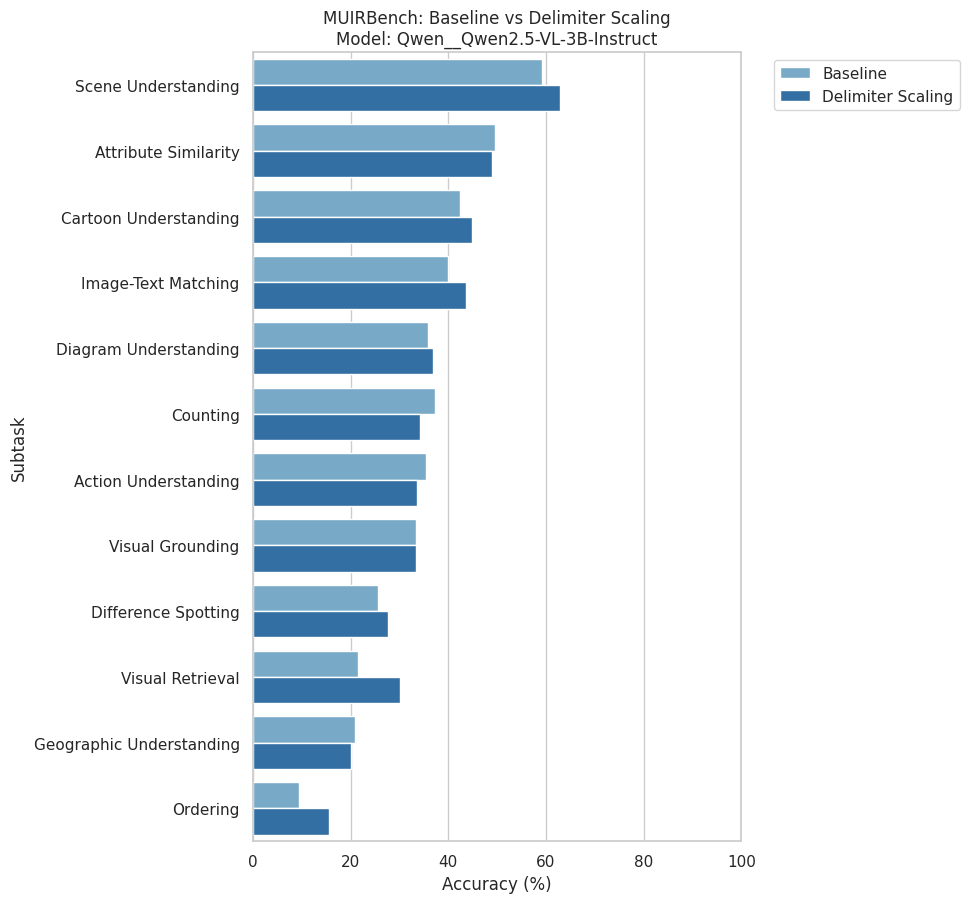

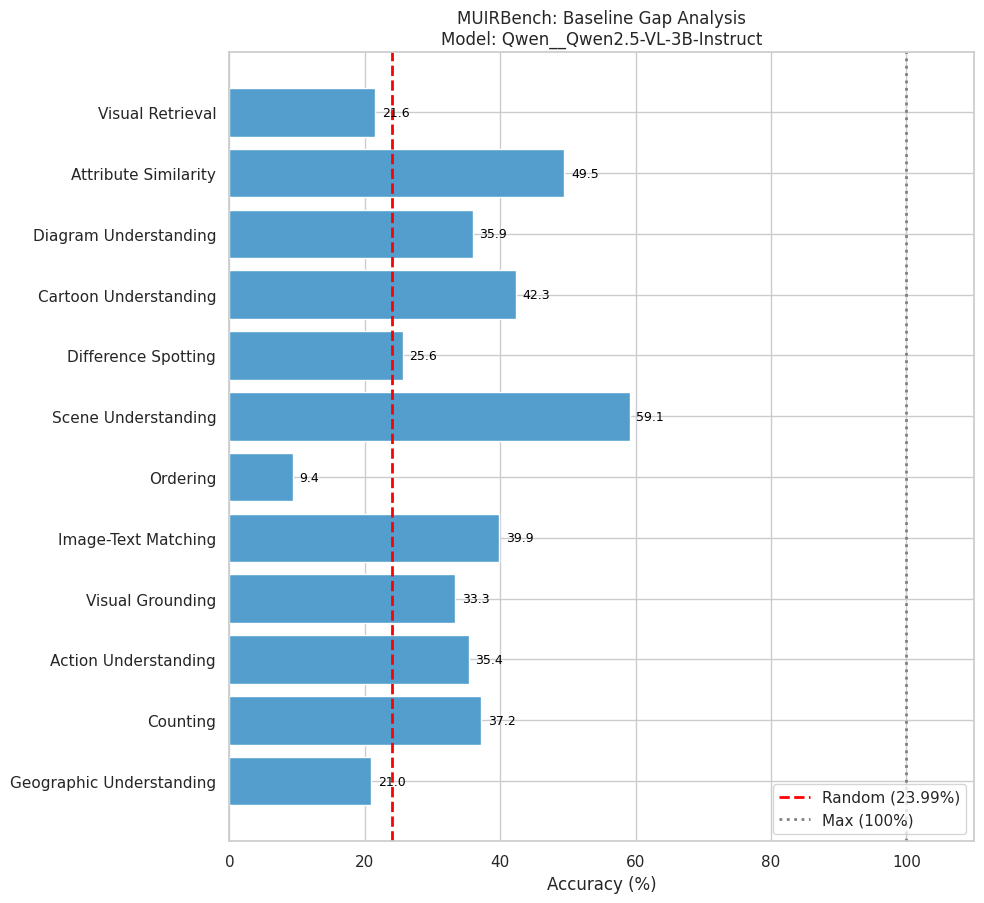


Done! Plots generated.


In [15]:
import json
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ==========================================
# 1. CONFIGURATION
# ==========================================

LOG_DIRECTORIES = {
    "Baseline": "/lustre/groups/eml/projects/huang/multi_image/lmms-eval/logs/baseline/",
    "Delimiter Scaling": "/lustre/groups/eml/projects/huang/multi_image/lmms-eval/logs/delimiter_scaling/"
}

RANDOM_CHANCE = {
    "Blink": 38.09,
    "MIRB": 23.02,
    "MUIRBench": 23.99
}

# ==========================================
# 2. DATA EXTRACTION
# ==========================================

def normalize_val(val):
    s = str(val).strip().lower()
    try:
        f_val = float(s)
        if f_val.is_integer(): return str(int(f_val))
    except: pass
    return s

def calculate_acc(correct, total):
    return (correct / total * 100) if total > 0 else 0.0

def parse_blink_subtasks(res_data):
    subtasks = {}
    if 'results' in res_data:
        for key, metrics in res_data['results'].items():
            if key.startswith('blink_') and key != 'blink':
                name = key.replace('blink_', '').replace('_', ' ').title()
                val = 0.0
                for m_k, m_v in metrics.items():
                    if isinstance(m_v, (int, float)) and 'stderr' not in m_k and 'alias' not in m_k:
                        val = m_v * 100
                        break
                subtasks[name] = val
    return subtasks

def parse_mirb_subtasks(file_path):
    stats = {}
    try:
        with open(file_path, 'r') as f:
            for line in f:
                entry = json.loads(line)
                info = entry.get('mirb_score', {})
                if not info: continue
                subset = info.get('subset', 'Unknown')
                pred_raw = info.get('pred_answer', [])
                pred_val = pred_raw[0] if isinstance(pred_raw, list) and pred_raw else pred_raw
                pred = normalize_val(pred_val)
                ans  = normalize_val(info.get('answers', ''))
                is_correct = (pred == ans)
                if subset not in stats: stats[subset] = {'c': 0, 't': 0}
                stats[subset]['t'] += 1
                if is_correct: stats[subset]['c'] += 1
    except Exception: return {}
    return {k: calculate_acc(v['c'], v['t']) for k, v in stats.items()}

def parse_muirbench_subtasks(file_path):
    stats = {}
    try:
        with open(file_path, 'r') as f:
            for line in f:
                entry = json.loads(line)
                info = entry.get('muirbench_score_overall', {})
                if not info: continue
                task = info.get('task', 'Unknown')
                pred = normalize_val(info.get('pred', ''))
                ans  = normalize_val(info.get('answer', ''))
                is_correct = (pred == ans)
                if task not in stats: stats[task] = {'c': 0, 't': 0}
                stats[task]['t'] += 1
                if is_correct: stats[task]['c'] += 1
    except Exception: return {}
    return {k: calculate_acc(v['c'], v['t']) for k, v in stats.items()}

# --- Main Data Loading ---
print("Starting Data Extraction...")
data_records = []

for experiment_label, base_path in LOG_DIRECTORIES.items():
    if not os.path.exists(base_path):
        print(f"Warning: Path not found: {base_path}")
        continue
        
    results_files = glob.glob(os.path.join(base_path, "**", "*_results.json"), recursive=True)
    
    for res_file in results_files:
        dir_name = os.path.dirname(res_file)
        base_name = os.path.basename(res_file).replace('_results.json', '')
        
        try:
            with open(res_file, 'r') as f:
                res_data = json.load(f)
                model_name = res_data.get('model_name_sanitized', res_data.get('model_name', 'Unknown'))
        except: continue

        # BLINK
        blink_scores = parse_blink_subtasks(res_data)
        for sub, score in blink_scores.items():
            data_records.append({'Model': model_name, 'Experiment': experiment_label, 'Benchmark': 'Blink', 'Subtask': sub, 'Score': score})

        # MIRB
        mirb_path = os.path.join(dir_name, f"{base_name}_samples_mirb.jsonl")
        if os.path.exists(mirb_path):
            mirb_scores = parse_mirb_subtasks(mirb_path)
            for sub, score in mirb_scores.items():
                data_records.append({'Model': model_name, 'Experiment': experiment_label, 'Benchmark': 'MIRB', 'Subtask': sub, 'Score': score})

        # MUIRBench
        muir_path = os.path.join(dir_name, f"{base_name}_samples_muirbench.jsonl")
        if os.path.exists(muir_path):
            muir_scores = parse_muirbench_subtasks(muir_path)
            for sub, score in muir_scores.items():
                data_records.append({'Model': model_name, 'Experiment': experiment_label, 'Benchmark': 'MUIRBench', 'Subtask': sub, 'Score': score})

df = pd.DataFrame(data_records)

# ==========================================
# 3. PLOTTING (Blues Color Scheme)
# ==========================================

if df.empty:
    print("No data found! Check paths.")
else:
    sns.set_theme(style="whitegrid")
    models = df['Model'].unique()
    benchmarks = ['Blink', 'MIRB', 'MUIRBench']
    
    # --- Define Blue Palettes ---
    # Palette for comparison (2 distinct blues)
    comp_blues = sns.color_palette("Blues", 3)
    comp_palette = {'Baseline': comp_blues[1], 'Delimiter Scaling': comp_blues[2]}

    # Palette for gap analysis (a single medium blue)
    gap_blue = sns.color_palette("Blues")[3]


    for model in models:
        print(f"\nProcessing Model: {model}")
        df_model = df[df['Model'] == model]

        for bench in benchmarks:
            df_bench = df_model[df_model['Benchmark'] == bench].copy()
            if df_bench.empty: continue
            
            sort_order = df_bench.groupby('Subtask')['Score'].mean().sort_values(ascending=False).index

            # -------------------------------------------------------
            # PLOT 1: Comparison (Baseline vs Delimiter Scaling)
            # -------------------------------------------------------
            plt.figure(figsize=(10, len(sort_order) * 0.6 + 2))
            
            sns.barplot(
                data=df_bench,
                y='Subtask', x='Score',
                hue='Experiment',
                order=sort_order,
                palette=comp_palette # Use blues palette
            )
            
            plt.title(f"{bench}: Baseline vs Delimiter Scaling\nModel: {model}")
            plt.xlabel("Accuracy (%)")
            plt.xlim(0, 100)
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()
            
            filename_comp = f"{bench}_Comparison_{model.replace('/', '_')}.png"
            # plt.savefig(filename_comp)
            # print(f"  Saved: {filename_comp}")
            plt.show()
            plt.close()

            # -------------------------------------------------------
            # PLOT 2: Gap Analysis (Baseline vs Random)
            # -------------------------------------------------------
            df_base = df_bench[df_bench['Experiment'] == 'Baseline']
            
            if not df_base.empty:
                plt.figure(figsize=(10, len(sort_order) * 0.6 + 2))
                
                # Bar Plot with a single blue color
                bars = plt.barh(df_base['Subtask'], df_base['Score'], color=gap_blue)
                
                # Reference Lines
                rand_val = RANDOM_CHANCE.get(bench, 0)
                plt.axvline(rand_val, color='red', linestyle='--', linewidth=2, label=f'Random ({rand_val}%)')
                plt.axvline(100, color='grey', linestyle=':', linewidth=2, label='Max (100%)')
                
                plt.title(f"{bench}: Baseline Gap Analysis\nModel: {model}")
                plt.xlabel("Accuracy (%)")
                plt.xlim(0, 110)
                plt.legend(loc='lower right')
                
                # Add value labels
                for bar in bars:
                    width = bar.get_width()
                    plt.text(width + 1, bar.get_y() + bar.get_height()/2, 
                             f'{width:.1f}', va='center', fontsize=9, color='black')

                plt.tight_layout()
                filename_gap = f"{bench}_GapAnalysis_{model.replace('/', '_')}.png"
                # plt.savefig(filename_gap)
                # print(f"  Saved: {filename_gap}")
                plt.show()
                plt.close()

print("\nDone! Plots generated.")